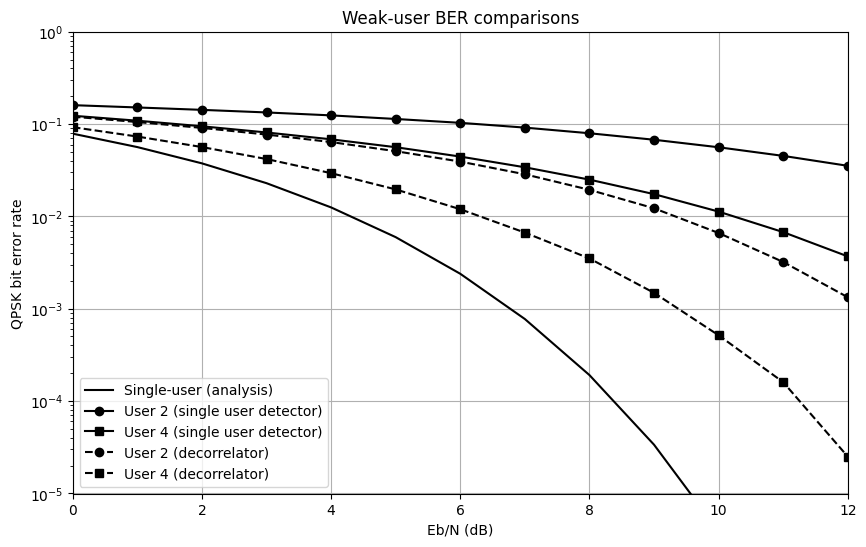

In [7]:
import numpy as np
from scipy.linalg import pinv
from scipy.special import erfc
import matplotlib.pyplot as plt

def get_gold_codes():
    # The specific Gold codes from the MATLAB code
    GPN = np.array([
        [1, 1, 1, -1], [-1, 1, -1, 1], [-1, -1, 1, 1], [1, 1, -1, -1],
        [-1, -1, -1, -1], [1, 1, 1, 1], [1, 1, -1, -1], [-1, -1, -1, 1],
        [-1, 1, -1, -1], [1, -1, -1, 1], [-1, -1, 1, 1], [1, 1, -1, 1],
        [1, -1, -1, -1], [-1, 1, 1, 1], [1, -1, 1, 1], [-1, 1, 1, -1],
        [-1, -1, 1, -1], [-1, 1, 1, -1], [1, 1, 1, -1], [1, -1, 1, 1],
        [1, -1, 1, -1], [1, 1, -1, -1], [1, 1, 1, 1], [1, 1, -1, -1],
        [-1, -1, -1, -1], [1, 1, -1, 1], [1, -1, -1, -1], [-1, 1, -1, 1],
        [1, 1, -1, -1], [1, 1, 1, 1], [1, 1, 1, 1]
    ])
    return GPN

def simulate_cdma(Ldata=100000):
    # System parameters
    Lc = 31  # spreading factor

    # Generate QPSK symbols
    data_sym = (2 * np.random.randint(0, 2, (Ldata, 4)) - 1 +
               1j * (2 * np.random.randint(0, 2, (Ldata, 4)) - 1))

    # Get Gold codes
    pcode = get_gold_codes()

    # Power matrix for near-far effect [10, 1, 5, 1]
    PowerMat = np.diag(np.sqrt([10, 1, 5, 1]))
    pcodew = pcode @ PowerMat

    # Correlation matrix and its inverse
    Rcor = pcodew.T @ pcodew
    Rinv = pinv(Rcor)

    # Spread the signals
    x_in = np.zeros(Ldata * Lc, dtype=complex)
    for i in range(4):
        x_in += np.kron(data_sym[:, i], pcodew[:, i])

    # Generate noise
    noiseq = np.random.randn(Ldata * Lc) + 1j * np.random.randn(Ldata * Lc)

    # Initialize BER storage
    Eb2N = np.arange(13)
    BERa2, BERa4 = [], []  # Conventional detector
    BERb2, BERb4 = [], []  # Decorrelator
    BER_az = []  # Analytical

    for eb_n0 in Eb2N:
        # Calculate noise variance
        eb_n0_linear = 10**(eb_n0/10)
        var_n = Lc/(2*eb_n0_linear)
        sig_noise = np.sqrt(var_n)

        # Add noise
        awgnois = sig_noise * noiseq
        y_out = x_in + awgnois

        # Reshape and despread
        Y_out = y_out.reshape(Ldata, Lc)
        z_out = Y_out @ pcode  # Conventional detector
        z_dcr = z_out @ Rinv   # Decorrelator

        # Make decisions
        dec1 = np.sign(z_out.real) + 1j * np.sign(z_out.imag)
        dec2 = np.sign(z_dcr.real) + 1j * np.sign(z_dcr.imag)

        # Calculate BER for users 2 and 4 (weak users)
        BERa2.append(np.sum((data_sym[:, 1].real != dec1[:, 1].real) |
                           (data_sym[:, 1].imag != dec1[:, 1].imag))/(2*Ldata))
        BERa4.append(np.sum((data_sym[:, 3].real != dec1[:, 3].real) |
                           (data_sym[:, 3].imag != dec1[:, 3].imag))/(2*Ldata))
        BERb2.append(np.sum((data_sym[:, 1].real != dec2[:, 1].real) |
                           (data_sym[:, 1].imag != dec2[:, 1].imag))/(2*Ldata))
        BERb4.append(np.sum((data_sym[:, 3].real != dec2[:, 3].real) |
                           (data_sym[:, 3].imag != dec2[:, 3].imag))/(2*Ldata))

        # Analytical BER
        BER_az.append(0.5 * erfc(np.sqrt(eb_n0_linear)))

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogy(Eb2N, BER_az, 'k-', label='Single-user (analysis)')
    plt.semilogy(Eb2N, BERa2, 'k-o', label='User 2 (single user detector)')
    plt.semilogy(Eb2N, BERa4, 'k-s', label='User 4 (single user detector)')
    plt.semilogy(Eb2N, BERb2, 'k--o', label='User 2 (decorrelator)')
    plt.semilogy(Eb2N, BERb4, 'k--s', label='User 4 (decorrelator)')

    plt.grid(True)
    plt.xlabel('Eb/N (dB)')
    plt.ylabel('QPSK bit error rate')
    plt.title('Weak-user BER comparisons')
    plt.legend()
    plt.ylim(0.99e-5, 1)
    plt.xlim(0, 12)
    plt.show()

simulate_cdma()

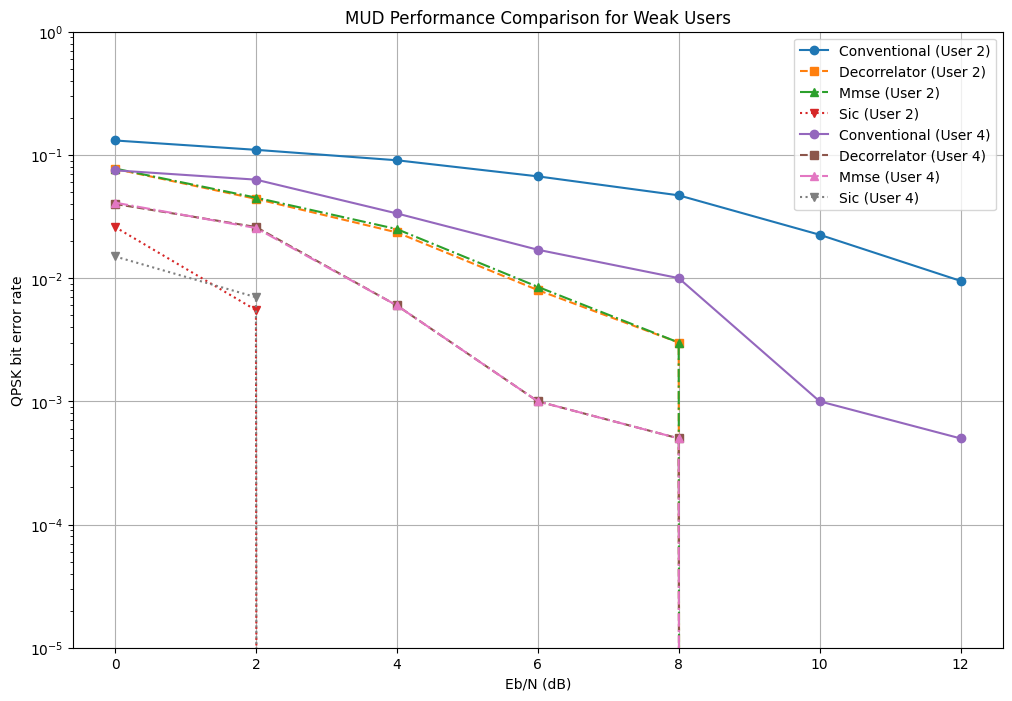

In [8]:
import numpy as np
from scipy.linalg import pinv, inv
from scipy.special import erfc
import matplotlib.pyplot as plt
from itertools import product

def get_gold_codes():
    # The specific Gold codes from previous example
    GPN = np.array([
        [1, 1, 1, -1], [-1, 1, -1, 1], [-1, -1, 1, 1], [1, 1, -1, -1],
        [-1, -1, -1, -1], [1, 1, 1, 1], [1, 1, -1, -1], [-1, -1, -1, 1],
        [-1, 1, -1, -1], [1, -1, -1, 1], [-1, -1, 1, 1], [1, 1, -1, 1],
        [1, -1, -1, -1], [-1, 1, 1, 1], [1, -1, 1, 1], [-1, 1, 1, -1],
        [-1, -1, 1, -1], [-1, 1, 1, -1], [1, 1, 1, -1], [1, -1, 1, 1],
        [1, -1, 1, -1], [1, 1, -1, -1], [1, 1, 1, 1], [1, 1, -1, -1],
        [-1, -1, -1, -1], [1, 1, -1, 1], [1, -1, -1, -1], [-1, 1, -1, 1],
        [1, 1, -1, -1], [1, 1, 1, 1], [1, 1, 1, 1]
    ])
    return GPN

class MUDDetectors:
    def __init__(self, pcode, power_levels):
        self.pcode = pcode
        self.power_levels = np.sqrt(power_levels)
        self.pcodew = pcode @ np.diag(self.power_levels)
        self.Rcor = self.pcodew.T @ self.pcodew

    def conventional(self, y_out):
        return y_out @ self.pcode

    def decorrelator(self, y_out):
        z_out = self.conventional(y_out)
        return z_out @ pinv(self.Rcor)

    def mmse(self, y_out, noise_var):
        z_out = self.conventional(y_out)
        P = np.diag(self.power_levels**2)
        mmse_matrix = inv(self.Rcor + noise_var * inv(P))
        return z_out @ mmse_matrix

    def ml_detector(self, y_out):
        # Exhaustive search over all possible symbol combinations
        n_users = self.pcode.shape[1]
        possible_symbols = [1+1j, 1-1j, -1+1j, -1-1j]
        min_distance = np.inf
        best_decision = None

        # For demonstration, only process first few samples
        for symbols in product(possible_symbols, repeat=n_users):
            symbols = np.array(symbols)
            expected_signal = np.zeros_like(y_out[0], dtype=complex)
            for i in range(n_users):
                expected_signal += symbols[i] * self.power_levels[i] * self.pcode[:, i]

            distance = np.abs(y_out[0] - expected_signal).sum()
            if distance < min_distance:
                min_distance = distance
                best_decision = symbols

        return np.array([best_decision])

    def sic_detector(self, y_out):
        n_users = self.pcode.shape[1]
        remaining_signal = y_out.copy()
        decisions = np.zeros((len(y_out), n_users), dtype=complex)

        # Order users by power
        user_order = np.argsort(self.power_levels)[::-1]

        for i in user_order:
            # Detect strongest remaining user
            z = remaining_signal @ self.pcode[:, i]
            decisions[:, i] = np.sign(z.real) + 1j * np.sign(z.imag)

            # Subtract this user's contribution
            reconstructed = np.outer(decisions[:, i], self.power_levels[i] * self.pcode[:, i])
            remaining_signal -= reconstructed

        return decisions

def simulate_mud_comparison(Ldata=1000):
    Lc = 31  # spreading factor
    power_levels = np.array([10, 1, 5, 1])  # Near-far scenario

    # Generate QPSK symbols
    data_sym = (2 * np.random.randint(0, 2, (Ldata, 4)) - 1 +
               1j * (2 * np.random.randint(0, 2, (Ldata, 4)) - 1))

    pcode = get_gold_codes()
    detectors = MUDDetectors(pcode, power_levels)

    Eb2N = np.arange(0, 13, 2)
    ber_results = {method: np.zeros((len(Eb2N), 4)) for method in
                  ['conventional', 'decorrelator', 'mmse', 'sic']}

    for i, eb_n0 in enumerate(Eb2N):
        eb_n0_linear = 10**(eb_n0/10)
        noise_var = Lc/(2*eb_n0_linear)

        # Generate received signal
        x_in = np.zeros((Ldata, Lc), dtype=complex)
        for u in range(4):
            x_in += np.outer(data_sym[:, u], pcode[:, u] * np.sqrt(power_levels[u]))

        noise = np.sqrt(noise_var/2) * (np.random.randn(*x_in.shape) +
                                      1j * np.random.randn(*x_in.shape))
        y_out = x_in + noise

        # Apply different detectors
        z_conv = detectors.conventional(y_out)
        z_dec = detectors.decorrelator(y_out)
        z_mmse = detectors.mmse(y_out, noise_var)
        z_sic = detectors.sic_detector(y_out)

        # Calculate BER for all users
        for u in range(4):
            for method, z_out in zip(['conventional', 'decorrelator', 'mmse', 'sic'],
                                   [z_conv, z_dec, z_mmse, z_sic]):
                dec = np.sign(z_out[:, u].real) + 1j * np.sign(z_out[:, u].imag)
                errors = np.sum((dec.real != data_sym[:, u].real) |
                              (dec.imag != data_sym[:, u].imag))
                ber_results[method][i, u] = errors/(2*Ldata)

    # Plot results
    plt.figure(figsize=(12, 8))
    methods = {'conventional': 'o-', 'decorrelator': 's--',
               'mmse': '^-.', 'sic': 'v:'}

    for u in [1, 3]:  # Plot only weak users (2 and 4)
        for method, marker in methods.items():
            plt.semilogy(Eb2N, ber_results[method][:, u], marker,
                        label=f'{method.capitalize()} (User {u+1})')

    plt.grid(True)
    plt.xlabel('Eb/N (dB)')
    plt.ylabel('QPSK bit error rate')
    plt.title('MUD Performance Comparison for Weak Users')
    plt.legend()
    plt.ylim(1e-5, 1)
    plt.show()

simulate_mud_comparison()

Based on this figure, we can draw several important conclusions about MUD performance for weak users (Users 2 and 4) in a near-far scenario:

1. Conventional Detector Performance:
- Shows worst performance (highest BER)
- Severely affected by near-far problem
- BER improves slowly with increasing Eb/N
- Not suitable for scenarios with large power differences

2. Decorrelator and MMSE:
- Significantly better than conventional detector
- Almost identical performance
- Much steeper BER improvement with Eb/N
- Effectively mitigate near-far interference

3. Successive Interference Cancellation (SIC):
- Best performance at low Eb/N
- Rapid error rate improvement
- Benefits from the clear power hierarchy
- Shows early error floor around 2dB

4. User Comparison:
- User 2 and User 4 (both weak users) show similar patterns
- Performance differences between detectors are consistent across users
- Validates the theoretical advantages of advanced MUD techniques

5. Overall Ranking (best to worst):
- SIC
- MMSE/Decorrelator (tied)
- Conventional

This demonstrates why advanced MUD techniques are crucial in practical CDMA systems with near-far effects.